In [2]:
from glob import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_csv_paths = list(glob(os.path.join('.', 'train_*.csv')))
valid_csv_paths = list(glob(os.path.join('.', 'valid_*.csv')))
assert len(train_csv_paths) > 0

In [3]:
df = pd.read_csv(train_csv_paths[0])

In [4]:
new_columns = {col: col.replace('validation__', '') for col in df.columns if col.startswith('validation__')}
df = df.rename(columns=new_columns)

In [5]:
unweighted_sample_cols = [
    str(col) for col in df.columns if 'unweigted_sample_loss' in col
]

In [46]:
epochs = sorted(list(set(df.epoch_id)))
epochs

[0, 1, 2, 3, 4, 5, 6, 7]

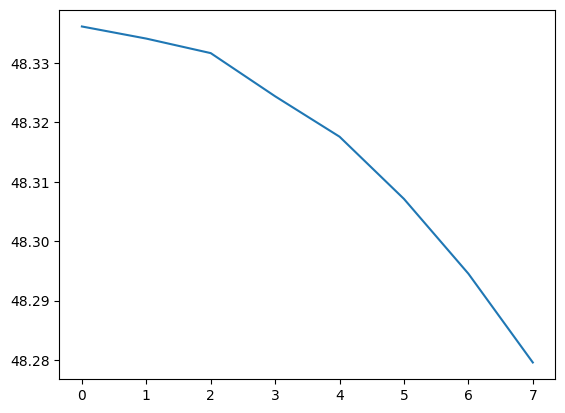

In [47]:
unweighted_losses = []
for i in epochs:
    loss = df.loc[df.epoch_id == i].iloc[:, df.columns.isin(unweighted_sample_cols)].sum(axis=1).mean()
    unweighted_losses.append(loss)
plt.plot(unweighted_losses)

<Figure size 640x480 with 0 Axes>

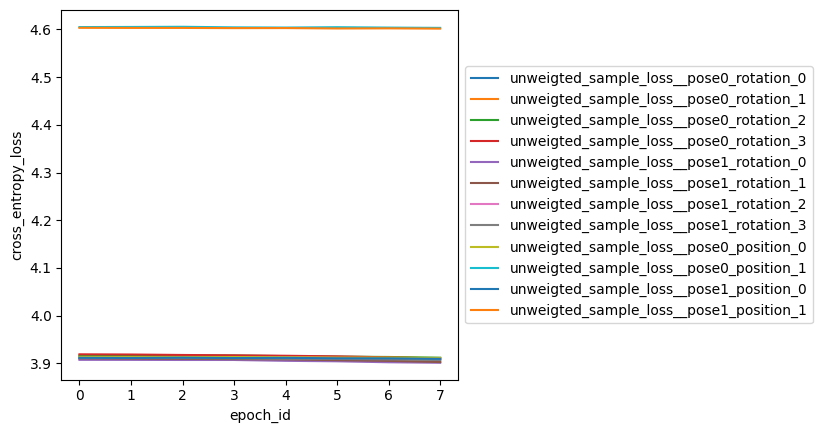

In [48]:
cols = list(df.columns)
rotation_cols = list(col for col in cols if '_rotation_' in col and 'sample_loss' in col)
position_cols = list(col for col in cols if '_position_' in col and 'sample_loss' in col)
fig = plt.figure()
mean_loss = df[rotation_cols + position_cols + ['epoch_id']].groupby('epoch_id').mean()
ax = mean_loss.plot(ylabel='cross_entropy_loss')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [49]:
per_task_loss = df[rotation_cols + position_cols + ['task']].groupby('task').sum().sum(axis=1).sort_values()
per_task_loss / per_task_loss.min()

task
novel_noun                    1.000000
sweep_without_exceeding       2.997638
visual_manipulation           2.998446
rotate                        2.998690
twist                         2.998754
rearrange                     2.999108
follow_order                  2.999192
rearrange_then_restore        2.999215
manipulate_old_neighbor       2.999313
scene_understanding           4.998000
pick_in_order_then_restore    6.000173
dtype: float64

Learning Rate

In [43]:
import math 
from playground.typing import TrainParam, DatasetParam

def get_lr_param():
    return {
        "warmup_end_at_iters": 0,
        "flatten_end_at_iters": 40000,
        "lr_decay_end_at_iters": 65000,
        "learning_rate": 1e-4,
        "min_lr": 1e-7, 
    }


def get_optimizer_param():
    return {
        "clip_norm": 1.0,
        "inital_lr": get_lr_param()["learning_rate"],
        "optimizer_name": "AdamW",
        "weight_decay": 0.0
    }

def get_dataset_param():
    return  {
        "data_pct_usage": 0.80,
        "total_data_size_per_task": 20000,
        "validation_pct": 0.01,
        "source": "s3://vima",
        "tasks": [
            "follow_order",
            "manipulate_old_neighbor",
            "novel_adj",
            "novel_noun",
            "pick_in_order_then_restore",
            "rearrange_then_restore",
            "rearrange",
            "rotate",
            "same_profile",
            "scene_understanding",
            "simple_manipulation",
            "sweep_without_exceeding",
            "twist",
        ]
    }

def get_train_param():
    return {
        "model_size": "2M",
        "total_epoch": 40,
        "local_batch_size": 128,
        "distributed": False,
    }
def get_lr(it: int) -> float:
    lr_param = get_lr_param()
    warmup_iters = lr_param["warmup_end_at_iters"]
    flatten_iters = lr_param["flatten_end_at_iters"]
    learning_rate = lr_param["learning_rate"]
    lr_decay_iters = lr_param["lr_decay_end_at_iters"]
    min_lr = lr_param["min_lr"]
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    if warmup_iters <= it < flatten_iters:
        return learning_rate
    if it > lr_decay_iters:
        return min_lr
    decay_ratio = (it - flatten_iters) / (lr_decay_iters - flatten_iters)
    assert 0 <= decay_ratio <= 1, f"{decay_ratio = }, {it = }"
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)


def get_batch_per_epoch(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        is_train: bool = True
    ):
    if is_train:
        scaling = 1.0
    else:
        scaling = dataset_param["validation_pct"]
    epoch_size = ( 
        int(
            dataset_param["total_data_size_per_task"] 
            * scaling 
            * len(dataset_param["tasks"]
        ) 
        * dataset_param["data_pct_usage"]) 
    )
    batch_size = (
        train_param["local_batch_size"] 
            if train_param["distributed"] is False 
            else train_param["local_batch_size"] * 1
    )
    if epoch_size % batch_size != 0:
        return epoch_size // batch_size + 1
    return epoch_size // batch_size

def get_total_batch_count(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        batch_id: int, 
        epoch_id: int,
        is_train: bool = True
    ) -> int:
    batch_count_per_epoch = get_batch_per_epoch(dataset_param, train_param, is_train)
    current_total_batch_count = batch_id + epoch_id * batch_count_per_epoch
    return current_total_batch_count

def measure_lr(
        dataset_param: DatasetParam,
        train_param: TrainParam,
        batch_id: int, 
        epoch_id: int
    ):
    current_total_batch_count = get_total_batch_count(
        dataset_param, 
        train_param, 
        batch_id, 
        epoch_id, 
        is_train=True
    )
    return get_lr(current_total_batch_count)

In [24]:
def get_lrs():
    lrs = []
    for epoch_id in range(get_train_param()["total_epoch"]):
        for batch_id in range(
            get_batch_per_epoch(
                get_dataset_param(),
                get_train_param(),
            )
        ):
            lrs.append(
                measure_lr(
                    get_dataset_param(),
                    get_train_param(),
                    batch_id,
                    epoch_id
                )
            )
    return lrs

65000


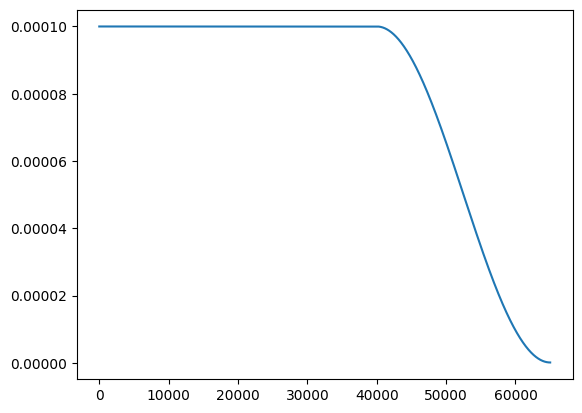

In [44]:
lrs = get_lrs()
print(len(lrs))
_ = plt.plot(lrs)

Eval Result

In [49]:
df = pd.read_csv('eval_2024-03-30.csv')

In [50]:
task_ids = {
    "visual_manipulation": "01",
    "scene_understanding": "02",
    "rotate": "03",
    "rearrange": "04",
    "rearrange_then_restore": "05",
    "novel_adj": "06",
    "novel_noun": "07",
    "novel_adj_and_noun": "08",
    "twist": "09",
    "follow_motion": "10",
    "follow_order": "11",
    "sweep_without_exceeding": "12",
    "sweep_without_touching": "13",
    "same_texture": "14",
    "same_shape": "15",
    "manipulate_old_neighbor": "16",
    "pick_in_order_then_restore": "17"
}

In [51]:


eval_success_rates = {
    task_ids[group.iloc[0]['task']]: round(float(group[['sucess']].mean().iloc[0] * 100), 1)
        for _, group in df.groupby('task')
}

In [52]:
sorted(list(eval_success_rates.items()))

[('01', 100.0),
 ('02', 100.0),
 ('03', 100.0),
 ('04', 73.0),
 ('05', 18.0),
 ('06', 99.0),
 ('07', 100.0),
 ('09', 20.0),
 ('11', 87.0),
 ('12', 83.0),
 ('15', 95.0),
 ('16', 44.0),
 ('17', 72.0)]

In [31]:
sorted(list(eval_success_rates.items()))

[('01', 66.0),
 ('02', 67.0),
 ('03', 43.0),
 ('04', 47.0),
 ('05', 9.0),
 ('06', 52.0),
 ('07', 67.0),
 ('09', 2.0),
 ('11', 50.0),
 ('12', 69.0),
 ('16', 50.0),
 ('17', 2.0)]